# UniModal Images Performance

## DEIT Model End to end training and evaluation

In [ ]:
import os

def get_folder_size(folder):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder):
        for file in filenames:
            file_path = os.path.join(dirpath, file)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

folder = "flattened_images_2"
size_bytes = get_folder_size(folder)
size_mb = size_bytes / (1024 * 1024)
size_gb = size_bytes / (1024 * 1024 * 1024)

print(f"Total size of '{folder}':")
print(f"  {size_bytes} bytes")
print(f"  {size_mb:.2f} MB")
print(f"  {size_gb:.2f} GB")


Total size of 'flattened_images_2':
  84489294400 bytes
  80575.27 MB
  78.69 GB


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report

#  Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_3.csv"
val_csv = "val_data_3.csv"
test_csv = "test_data_3.csv"
image_dir = "preprocessed_images_3"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

#  Load DeiT-Base Model and Image Processor with classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True
).to(device)

# Define label mapping
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]

        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

#  Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

#  Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

#  Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

#  Evaluate Model on Test Set and Compute Classification Report
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

# Compute and print classification report
report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 1/10 | Train Loss: 1.0638, Train Acc: 0.4623 | Val Loss: 1.0175, Val Acc: 0.4971
Best model saved.
Epoch 2/10 | Train Loss: 0.9520, Train Acc: 0.5439 | Val Loss: 0.8992, Val Acc: 0.6192
Best model saved.
Epoch 3/10 | Train Loss: 0.4299, Train Acc: 0.8243 | Val Loss: 1.0173, Val Acc: 0.5610
Epoch 4/10 | Train Loss: 0.0396, Train Acc: 0.9938 | Val Loss: 1.1181, Val Acc: 0.6337
Epoch 5/10 | Train Loss: 0.0086, Train Acc: 0.9988 | Val Loss: 1.1097, Val Acc: 0.6773
Early stopping triggered.
🔥 Test Accuracy: 0.6522
Classification Report:
              precision    recall  f1-score   support

          CN       0.61      0.59      0.60       106
         MCI       0.69      0.76      0.72       167
          AD       0.62      0.49      0.55        72

    accuracy                           0.65       345
   macro avg       0.64      0.61      0.62       345
weighted avg       0.65      0.65      0.65       345



## Using MLP

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features
##########################################
# Load DeiT features.
train_features = np.load("Deit_train_features_1.npy")
val_features   = np.load("Deit_val_features_1.npy")
test_features  = np.load("Deit_test_features_1.npy")

print("Train features shape:", train_features.shape)
print("Val features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")


label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )

    def forward(self, x):
        return self.net(x)

# Example usage:
input_dim = train_features.shape[1]
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)


##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 200
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)

    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Train features shape: (1605, 768)
Val features shape: (344, 768)
Test features shape: (345, 768)
Epoch 1/200: Train Loss = 1.0683, Val Loss = 1.0389, Val Acc = 0.4855
  -> New best model saved.
Epoch 2/200: Train Loss = 1.0490, Val Loss = 1.0353, Val Acc = 0.4855
  -> New best model saved.
Epoch 3/200: Train Loss = 1.0480, Val Loss = 1.0324, Val Acc = 0.4855
  -> New best model saved.
Epoch 4/200: Train Loss = 1.0396, Val Loss = 1.0306, Val Acc = 0.4855
  -> New best model saved.
Epoch 5/200: Train Loss = 1.0326, Val Loss = 1.0289, Val Acc = 0.4855
  -> New best model saved.
Epoch 6/200: Train Loss = 1.0371, Val Loss = 1.0265, Val Acc = 0.4855
  -> New best model saved.
Epoch 7/200: Train Loss = 1.0277, Val Loss = 1.0248, Val Acc = 0.4855
  -> New best model saved.
Epoch 8/200: Train Loss = 1.0270, Val Loss = 1.0230, Val Acc = 0.4855
  -> New best model saved.
Epoch 9/200: Train Loss = 1.0305, Val Loss = 1.0210, Val Acc = 0.4855
  -> New best model saved.
Epoch 10/200: Train Loss = 1.0

# Uni Modal Tabular Data performance

## Ft Transformer end to end training and evalaution

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

seed = 42  # choose your seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)





In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rtdl_revisiting_models import FTTransformer

##########################################
# 1. Load and Preprocess the Data
##########################################
# Load CSV files for train, validation, and test splits.
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

# Define feature columns and target label.
numerical_features = ["Age", "CDGLOBAL", "CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
categorical_features = ["GENOTYPE"]
label = "Group"

# Subset dataframes to desired columns.
cols = numerical_features + categorical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]

# Handle missingness for numerical features.
cols_with_missing = ["CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
for col in cols_with_missing:
    for df in [train_data, val_data, test_data]:
        df[col + "_is_missing"] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(-999)

# Extend continuous features to include missing indicators.
numerical_features_extended = numerical_features + [col + "_is_missing" for col in cols_with_missing]

# Encode categorical features using LabelEncoder.
cat_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    val_data[col]   = le.transform(val_data[col].astype(str))
    test_data[col]  = le.transform(test_data[col].astype(str))
    cat_encoders[col] = le

# Encode the target.
label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])
num_classes = len(label_encoder.classes_)

##########################################
# 2. Prepare NumPy Arrays and Create Dataset
##########################################
# Continuous features.
X_train_cont = train_data[numerical_features_extended].values.astype(np.float32)
X_val_cont   = val_data[numerical_features_extended].values.astype(np.float32)
X_test_cont  = test_data[numerical_features_extended].values.astype(np.float32)

# Categorical features.
X_train_cat = train_data[categorical_features].values.astype(np.int64)
X_val_cat   = val_data[categorical_features].values.astype(np.int64)
X_test_cat  = test_data[categorical_features].values.astype(np.int64)

# Labels.
y_train = train_data[label].values.astype(np.int64)
y_val   = val_data[label].values.astype(np.int64)
y_test  = test_data[label].values.astype(np.int64)

# Create a simple PyTorch Dataset.
class TabularDataset(Dataset):
    def __init__(self, cont, cat, labels):
        self.cont = cont
        self.cat = cat
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "cat": torch.tensor(self.cat[idx], dtype=torch.long),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, X_train_cat, y_train)
val_dataset   = TabularDataset(X_val_cont, X_val_cat, y_val)
test_dataset  = TabularDataset(X_test_cont, X_test_cat, y_test)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 3. Initialize and Train the FTTransformer Classifier
##########################################
# Get the number of continuous features.
n_cont_features = X_train_cont.shape[1]
cat_cardinalities = [int(train_data[col].nunique()) for col in categorical_features]

# For classification, set d_out = number of classes.
d_out = num_classes

# Instantiate the FTTransformer.
model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    n_blocks=3,
    d_block=192,                # Backbone (hidden) dimension
    attention_n_heads=8,
    attention_dropout=0.2,
    ffn_d_hidden=None,
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up optimizer, loss function, and scheduler.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training loop with early stopping.
max_epochs = 100
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)

        optimizer.zero_grad()
        logits = model(cont, cat)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * cont.size(0)
    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            cont = batch["cont"].to(device)
            cat = batch["cat"].to(device)
            targets = batch["target"].to(device)

            logits = model(cont, cat)
            loss = criterion(logits, targets)
            val_loss += loss.item() * cont.size(0)
    val_loss /= len(val_dataset)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the best model.
save_model_path = "best_ft_transformer_classification.pt"
torch.save(best_model_state, save_model_path)
print("Trained model saved to", save_model_path)

# Load the best model.
model.load_state_dict(torch.load(save_model_path))

# Evaluate classification performance on the test set.
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)

        logits = model(cont, cat)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 1.0557 | Val Loss: 1.0274
Epoch 2: Train Loss: 1.0233 | Val Loss: 0.9525
Epoch 3: Train Loss: 0.7375 | Val Loss: 0.4822
Epoch 4: Train Loss: 0.4742 | Val Loss: 0.3990
Epoch 5: Train Loss: 0.4257 | Val Loss: 0.3785
Epoch 6: Train Loss: 0.3891 | Val Loss: 0.3898
Epoch 7: Train Loss: 0.3681 | Val Loss: 0.3462
Epoch 8: Train Loss: 0.3403 | Val Loss: 0.3471
Epoch 9: Train Loss: 0.3667 | Val Loss: 0.3960
Epoch 10: Train Loss: 0.3602 | Val Loss: 0.3369
Epoch 11: Train Loss: 0.3360 | Val Loss: 0.3430
Epoch 12: Train Loss: 0.3377 | Val Loss: 0.3402
Epoch 13: Train Loss: 0.3413 | Val Loss: 0.3201
Epoch 14: Train Loss: 0.3366 | Val Loss: 0.3385
Epoch 15: Train Loss: 0.3308 | Val Loss: 0.3481
Epoch 16: Train Loss: 0.3233 | Val Loss: 0.3290
Epoch 17: Train Loss: 0.3308 | Val Loss: 0.3324
Epoch 18: Train Loss: 0.3194 | Val Loss: 0.3325
Early stopping triggered.
Trained model saved to best_ft_transformer_classification.pt
Test Accuracy: 0.9043478260869565
Classification Report (T

/tmp/ipykernel_789196/921975057.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))


## Early Fusion

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

# Concatenate features along the last axis.
train_features = np.concatenate((deit_train, ft_train), axis=1)
val_features   = np.concatenate((deit_val, ft_val), axis=1)
test_features  = np.concatenate((deit_test, ft_test), axis=1)

print("Fused train features shape:", train_features.shape)
print("Fused val features shape:", val_features.shape)
print("Fused test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")


label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )

    def forward(self, x):
        return self.net(x)


input_dim = train_features.shape[1]
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)


##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)

    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Fused train features shape: (1605, 960)
Fused val features shape: (344, 960)
Fused test features shape: (345, 960)
Epoch 1/100: Train Loss = 1.0067, Val Loss = 0.9130, Val Acc = 0.6017
  -> New best model saved.
Epoch 2/100: Train Loss = 0.8532, Val Loss = 0.7509, Val Acc = 0.7674
  -> New best model saved.
Epoch 3/100: Train Loss = 0.7080, Val Loss = 0.5965, Val Acc = 0.7791
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5748, Val Loss = 0.4862, Val Acc = 0.8052
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4803, Val Loss = 0.4129, Val Acc = 0.8459
  -> New best model saved.
Epoch 6/100: Train Loss = 0.4219, Val Loss = 0.3661, Val Acc = 0.8808
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3768, Val Loss = 0.3411, Val Acc = 0.8808
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3560, Val Loss = 0.3246, Val Acc = 0.8837
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3415, Val Loss = 0.3150, Val Acc = 0.8837
  -> New best model saved.
Epoch 10/100

## Mid Fusion

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load DeiT features
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   # Dimensionality reduction from 768 to 384
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   # Dimensionality reduction from 192 to 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenated features from both branches (308+128=436)
        self.classifier = nn.Sequential(
            nn.Linear(436, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)
        ft_output = self.ft_fc(ft_input)
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)
        # Classify
        logits = self.classifier(concatenated_features)
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]
tab_input_size = train_features_ft.shape[1]

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)


# 5. Prepare the data loaders
# Convert to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor = torch.tensor(test_features_ft, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf

num_epochs = 100

# 7. Training Loop with Validation and Early Stopping mechanism
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# 8. Evaluate the Model on the Test Set
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.0254, Train Acc: 0.4729 Val Loss: 0.9001, Val Acc: 0.7587
Best model saved.
Epoch [2/100] Train Loss: 0.8606, Train Acc: 0.6617 Val Loss: 0.7841, Val Acc: 0.8430
Best model saved.
Epoch [3/100] Train Loss: 0.7354, Train Acc: 0.7751 Val Loss: 0.6766, Val Acc: 0.8517
Best model saved.
Epoch [4/100] Train Loss: 0.6467, Train Acc: 0.8224 Val Loss: 0.6163, Val Acc: 0.8488
Best model saved.
Epoch [5/100] Train Loss: 0.5909, Train Acc: 0.8293 Val Loss: 0.5412, Val Acc: 0.8576
Best model saved.
Epoch [6/100] Train Loss: 0.5464, Train Acc: 0.8505 Val Loss: 0.4938, Val Acc: 0.8547
Best model saved.
Epoch [7/100] Train Loss: 0.4950, Train Acc: 0.8679 Val Loss: 0.4852, Val Acc: 0.8547
Best model saved.
Epoch [8/100] Train Loss: 0.4632, Train Acc: 0.8760 Val Loss: 0.4881, Val Acc: 0.8547
Epoch [9/100] Train Loss: 0.4428, Train Acc: 0.8766 Val Loss: 0.4319, Val Acc: 0.8517
Best model saved.
Epoch [10/100] Train Loss: 0.4066, Train Acc: 0.8810 Val Loss: 0.4142, Val Acc: 0.

/tmp/ipykernel_2616349/265524843.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.9246

Classification Report:
              precision    recall  f1-score   support

          AD       0.87      0.85      0.86        72
          CN       0.99      0.95      0.97       106
         MCI       0.91      0.94      0.92       167

    accuracy                           0.92       345
   macro avg       0.92      0.91      0.92       345
weighted avg       0.93      0.92      0.92       345

Confusion Matrix:
[[ 61   0  11]
 [  0 101   5]
 [  9   1 157]]


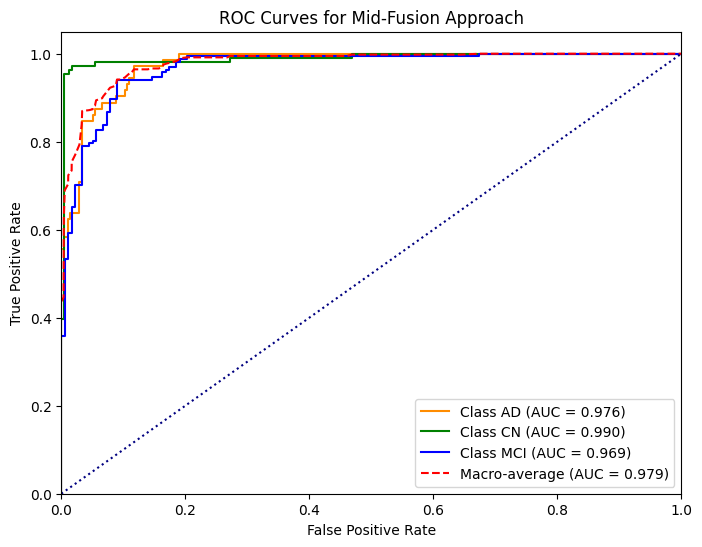

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt



model.eval()
total_test_correct = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        probs = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# ------------------- ROC and AUC Calculation -------------------

num_classes = len(label_encoder.classes_)

# Binarize the labels for each class
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Convert all_probs to a numpy array
y_score = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
colors = ["darkorange", "green", "blue"]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})")

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"], color="red", linestyle="--",
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle=":")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Mid-Fusion Approach")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for one-vs-rest evaluation
y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_percentage = roc_auc[i] * 100
    print(f"Class {i} AUC: {roc_auc[i]:.4f} which is {auc_percentage:.2f}%")


Class 0 AUC: 0.9764 which is 97.64%
Class 1 AUC: 0.9899 which is 98.99%
Class 2 AUC: 0.9687 which is 96.87%


In [ ]:
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro AUC: {macro_auc*100:.2f}%")


Macro AUC: 97.83%


## End of notebook